In [1]:

from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)

In [2]:

df1 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_1.csv")
df2 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_2.csv")
df3 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_3.csv")
df4 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_4.csv")

df5 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_-1.csv")
df6 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_-2.csv")
df7 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_-3.csv")
df8 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_-4.csv")
df9 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/All_Trading_Applicatoins/price_levels/simulation_-5.csv")





In [4]:
def time_independent_features(df, price_level_num, buy_amount):
    # Get Size of buy amount
    def get_volume_of_value(side, df):
        total_value = 0
        total_volume = 0
        curr_level = 1
        while total_value < buy_amount and curr_level <= price_level_num:
            curr_price_level = df[f"{side} Price Level {curr_level}"]
            curr_volume_level = df[f"{side} Volume Level {curr_level}"]
            curr_value = curr_price_level * curr_volume_level
            if total_value + curr_value > buy_amount:
                remaining_needed_value = buy_amount - total_value
                total_volume += (remaining_needed_value / curr_price_level)
                total_value = buy_amount
            else:
                total_value += curr_value
                total_volume += curr_volume_level

            curr_level +=1

        return total_volume
    
    df[f"Volume of {buy_amount} Bid Value"] = df.apply(lambda row: get_volume_of_value("Bid", row), axis = 1)
    df[f"Volume of {buy_amount} Ask Value"] = df.apply(lambda row: get_volume_of_value("Ask", row), axis = 1)
    # Mid Price
    # df["Mid Price"] = (df["Bid Price Level 1"] + df["Ask Price Level 1"]) / 2
    # # Mid Price Velocity
    # df["Mid Price Velocity"] = df["Mid Price"] - df["Mid Price"].shift(1)
    # # Mid Price Acceleration
    # df["Mid Price Acceleration"] = df["Mid Price Velocity"] - df["Mid Price Velocity"].shift(1)
    # # Bid Ask Spread
    # df["Bid Ask Spread"] = (df["Bid Price Level 1"] - df["Ask Price Level 1"])


    
    df[f"Volume of {buy_amount} Bid Ask Mid Value"] = (df[f"Volume of {buy_amount} Bid Value"] + df[f"Volume of {buy_amount} Ask Value"]) / 2

    df[f"Volume of {buy_amount} Bid Ask Mid Value Spread"] = (df[f"Volume of {buy_amount} Bid Value"] - df[f"Volume of {buy_amount} Ask Value"])

    df[f"Volume of {buy_amount} Bid Ask Mid Value Velocity"] =  df[f"Volume of {buy_amount} Bid Ask Mid Value"] - df[f"Volume of {buy_amount} Bid Ask Mid Value"].shift(1)

    df[f"Volume of {buy_amount} Bid Ask Mid Value Acceleration"] =  df[f"Volume of {buy_amount} Bid Ask Mid Value Velocity"] - df[f"Volume of {buy_amount} Bid Ask Mid Value Velocity"].shift(1)






    # Volume Level Log Bid & Ask
    for i in range(price_level_num):
        df[f"Bid Volume Level {i+1} Log"] = np.log(df[f"Bid Volume Level {i+1}"])
    for i in range(price_level_num):
        df[f"Ask Volume Level {i+1} Log"] = np.log(df[f"Ask Volume Level {i+1}"])
    # Volume Level Difference Bid & Ask
    for i in range(1,price_level_num):
        df[f'Bid Volume Diff {i}'] = df[f'Bid Volume Level {i+1}'] - df[f'Bid Volume Level {i}']
    for i in range(1,price_level_num):
        df[f'Ask Volume Diff {i}'] = df[f'Ask Volume Level {i+1}'] - df[f'Ask Volume Level {i}']
    # Imbalance
    df["Imbalance"] = (df["Bid Volume Level 1"] - df["Ask Volume Level 1"]) / (df["Bid Volume Level 1"] + df["Ask Volume Level 1"])
    # VWAP Bid & Ask
    def vwap_helper(df, side, levels):
        total_volume = sum(df[[f"{side} Volume Level {i}" for i in range(1,levels+1)]])
        vwap = sum(df[f'{side} Price Level {i}'] * df[f'{side} Volume Level {i}'] for i in range(1, levels+1)) / total_volume
        return vwap
    df[f"Bid VWAP {price_level_num}"] = df.apply(lambda row: vwap_helper(row, "Bid", price_level_num), axis = 1)
    df[f"Ask VWAP {price_level_num}"] = df.apply(lambda row: vwap_helper(row, "Ask", price_level_num), axis = 1)
    # Total Volume Bid & Ask
    df[f"Total Bid Volume {price_level_num}"] = df[[f'Bid Volume Level {i}' for i in range(1, price_level_num+1)]].sum(axis=1)
    df[f"Total Ask Volume {price_level_num}"] = df[[f'Ask Volume Level {i}' for i in range(1, price_level_num+1)]].sum(axis=1)
    # Price Range
    df["Price Range"] = df[f"Ask Price Level {price_level_num}"] - df[f"Bid Price Level {price_level_num}"]
    # Time Difference
    df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='ISO8601')
    df['Time Since Last Update'] = df['Timestamp'].diff().dt.total_seconds()


    return df
    

In [5]:
def time_dependent_features(df, windows, buy_amount):
    
    # Mid Price Volatility Calculation
    def volatility_helper(i, series, window):
        if i - window + 1 >= 0:
            std = series[i-window+1:i+1].std()
            return std
        return np.nan
    
    mid_price_series = df[f"Volume of {buy_amount} Bid Ask Mid Value"]
    
    for window in windows:
        if window == 1:
            continue
        df[f"Volume of {buy_amount} Bid Ask Mid Value Volatility {window}"] = df.index.to_series().apply(
            lambda i: volatility_helper(i, mid_price_series, window)
        )

    def create_sma_helper(series, window):
        sma = [None] * len(series)
        for i in range(len(series)):
            if i >= window:
                sma[i] = sum(series[i-window+1:i+1]) / window
        return sma

    def create_rate_of_change_helper(series):
        roc = [None]*len(series)
        for i in range(1,len(series)):
            if series[i-1]!=0:
                roc[i] = (series[i]-series[i-1] / series[i-1])
        return roc

    def create_ema_helper(series, window):
        alpha = 2 / (window+1)
        ema = [None]*len(series)
        ema[0] = series[0]
        for i in range(1, len(series)):
            ema[i] = (alpha * series[i] + (1-alpha) * ema[i-1])
        return ema

    def create_rsi_helper(series, window):
        deltas = [None]*len(series)
        for i in range(1,len(series)):
            deltas[i] = series[i] - series[i-1]
    
        gains = [max(delta, 0) if delta is not None else None for delta in deltas]
        losses = [-min(delta, 0) if delta is not None else None for delta in deltas]
    
        avg_gains = create_sma_helper(gains,window)
        avg_losses = create_sma_helper(losses,window)
    
        rs = [None]*len(series)
        rsi = [None]* len(series)
    
        for i in range(len(series)):
            if avg_gains[i] is None or avg_losses[i] is None:
                continue
                
            if avg_losses[i] == 0:
                rsi[i] = 100
            else:
                rs_value = avg_gains[i] / avg_losses[i]
                rs[i] = rs_value
                rsi[i] = (100 - (100 / (1 + rs_value)))
        return rsi

    for window in windows:
        df[f"Volume of {buy_amount} Bid Ask Mid Value SMA {window}"] = create_sma_helper(mid_price_series, window)

    df[f"Volume of {buy_amount} Bid Ask Mid Value ROC"] = create_rate_of_change_helper(mid_price_series)

    for window in windows:
        df[f"Volume of {buy_amount} Bid Ask Mid Value EMA {window}"] = create_ema_helper(mid_price_series, window)

    df[f"Volume of {buy_amount} Bid Ask Mid Value RSI"] = create_rsi_helper(series = mid_price_series, window=14)

    return df




    
    

In [6]:
def create_time_lag(df, sell_column, time_lag):
    df[f"{sell_column} Time Lag {time_lag}"] = df[sell_column].shift(-time_lag)
    return df

In [7]:
def create_gain_binary(df, buy_column, sell_column, time_lag):
    classifier_df = df.copy()
    classifier_df[f"Gain"] = classifier_df[buy_column] > classifier_df[f"{sell_column} Time Lag {time_lag}"]
    return classifier_df

In [8]:
def create_dataset_helper(df, sell_column, price_level_num, time_lag, windows, buy_amount, buy_column):

    # Feature Columns
    df_copy = df.copy()
    df_copy = time_independent_features(df_copy,price_level_num, buy_amount)
    df_copy = time_dependent_features(df_copy, windows, buy_amount)

    # Target column
    df_copy = create_time_lag(df = df_copy, sell_column = sell_column, time_lag = time_lag)
    df_copy = df_copy.dropna(ignore_index = True)
    df_copy = create_gain_binary(df_copy, buy_column, sell_column, time_lag)

    return df_copy



def create_dataset(dfs, sell_column, price_level_num, time_lag, windows, buy_amount, buy_column):
    res_df = pd.DataFrame()
    
    for df in dfs:
        df_done = create_dataset_helper(df, sell_column, price_level_num, time_lag, windows, buy_amount, buy_column)
        res_df = pd.concat([res_df, df_done], ignore_index = True)

    return res_df

In [9]:
def graph(y_actual, y_pred, start = None, end = None):

    if not start:
        start = 0
    if not end:
        end = len(y_actual)

    
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(y_actual))[start:end], y_actual[start:end], label="Actual", color='blue', linewidth=2)
    plt.plot(np.arange(len(y_pred))[start:end], y_pred[start:end], label="Predicted", color='red', linestyle='dashed', linewidth=2)
    #plt.plot(np.arange(len(mid_price))[start:end], mid_price[start:end], label="Mid Price", color='green', linestyle='dashed', linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [10]:
def calculate_weights(model):

    feature_importance = model.feature_importances_
    
    # If X is a DataFrame, use column names; otherwise, generate names
    feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]
    
    # Create a dictionary of feature names and their importance
    feature_importance_dict = dict(zip(feature_names, feature_importance))
    
    return feature_importance_dict



In [11]:
##################################
######### CREATE DATASET #########
##################################
dfs = [df1,df2,df3,df4,df5,df6,df7,df8,df9]
buy_amount = 10
buy_column = f"Volume of {buy_amount} Ask Value"
sell_column = f"Volume of {buy_amount} Bid Value"
price_level_num = 10
time_lag = 20
windows = [1,2,5,10]
full_df = create_dataset(dfs=dfs, sell_column = sell_column, price_level_num = price_level_num, time_lag = time_lag, windows = windows, buy_amount = buy_amount, buy_column = buy_column)

In [12]:
column_n = len(full_df.columns)

print(full_df.columns[(column_n//2):])

Index(['Bid Volume Level 7 Log', 'Bid Volume Level 8 Log',
       'Bid Volume Level 9 Log', 'Bid Volume Level 10 Log',
       'Ask Volume Level 1 Log', 'Ask Volume Level 2 Log',
       'Ask Volume Level 3 Log', 'Ask Volume Level 4 Log',
       'Ask Volume Level 5 Log', 'Ask Volume Level 6 Log',
       'Ask Volume Level 7 Log', 'Ask Volume Level 8 Log',
       'Ask Volume Level 9 Log', 'Ask Volume Level 10 Log',
       'Bid Volume Diff 1', 'Bid Volume Diff 2', 'Bid Volume Diff 3',
       'Bid Volume Diff 4', 'Bid Volume Diff 5', 'Bid Volume Diff 6',
       'Bid Volume Diff 7', 'Bid Volume Diff 8', 'Bid Volume Diff 9',
       'Ask Volume Diff 1', 'Ask Volume Diff 2', 'Ask Volume Diff 3',
       'Ask Volume Diff 4', 'Ask Volume Diff 5', 'Ask Volume Diff 6',
       'Ask Volume Diff 7', 'Ask Volume Diff 8', 'Ask Volume Diff 9',
       'Imbalance', 'Bid VWAP 10', 'Ask VWAP 10', 'Total Bid Volume 10',
       'Total Ask Volume 10', 'Price Range', 'Time Since Last Update',
       'Volume of 10 

In [13]:
feature_columns = [
    'Bid Price Level 1', 'Bid Volume Level 1',
    'Bid Price Level 2', 'Bid Volume Level 2', 
    'Bid Price Level 3', 'Bid Volume Level 3', 
    # 'Bid Price Level 4', 'Bid Volume Level 4',
    # 'Bid Price Level 5', 'Bid Volume Level 5', 
    # 'Bid Price Level 6', 'Bid Volume Level 6', 
    # 'Bid Price Level 7', 'Bid Volume Level 7',
    # 'Bid Price Level 8', 'Bid Volume Level 8', 
    # 'Bid Price Level 9', 'Bid Volume Level 9', 
    # 'Bid Price Level 10', 'Bid Volume Level 10',
    'Ask Price Level 1', 'Ask Volume Level 1', 
    'Ask Price Level 2', 'Ask Volume Level 2', 
    'Ask Price Level 3', 'Ask Volume Level 3',
    # 'Ask Price Level 4', 'Ask Volume Level 4', 
    # 'Ask Price Level 5','Ask Volume Level 5', 
    # 'Ask Price Level 6', 'Ask Volume Level 6',
    # 'Ask Price Level 7', 'Ask Volume Level 7', 
    # 'Ask Price Level 8', 'Ask Volume Level 8', 
    # 'Ask Price Level 9', 'Ask Volume Level 9',
    # 'Ask Price Level 10', 'Ask Volume Level 10', 
    'Volume of 10 Bid Value', 'Volume of 10 Ask Value',
    # 'Volume of 10 Bid Ask Mid Value',
    'Volume of 10 Bid Ask Mid Value Spread',
    'Volume of 10 Bid Ask Mid Value Velocity',
    'Volume of 10 Bid Ask Mid Value Acceleration', 
    'Bid Volume Level 1 Log',
    'Bid Volume Level 2 Log', 
    'Bid Volume Level 3 Log',
    'Bid Volume Level 4 Log', 
    'Bid Volume Level 5 Log',
    'Bid Volume Level 6 Log',
    'Bid Volume Level 7 Log', 
    # 'Bid Volume Level 8 Log',
    # 'Bid Volume Level 9 Log', 
    # 'Bid Volume Level 10 Log',
    'Ask Volume Level 1 Log', 
    'Ask Volume Level 2 Log',
    'Ask Volume Level 3 Log', 
    'Ask Volume Level 4 Log',
    'Ask Volume Level 5 Log', 
    'Ask Volume Level 6 Log',
    'Ask Volume Level 7 Log', 
    # 'Ask Volume Level 8 Log',
    # 'Ask Volume Level 9 Log', 
    # 'Ask Volume Level 10 Log',
    'Bid Volume Diff 1', 'Bid Volume Diff 2', 'Bid Volume Diff 3',
    # 'Bid Volume Diff 4', 'Bid Volume Diff 5', 'Bid Volume Diff 6',
    # 'Bid Volume Diff 7', 'Bid Volume Diff 8', 'Bid Volume Diff 9',
    'Ask Volume Diff 1', 'Ask Volume Diff 2', 'Ask Volume Diff 3',
    # 'Ask Volume Diff 4', 'Ask Volume Diff 5', 'Ask Volume Diff 6',
    # 'Ask Volume Diff 7', 'Ask Volume Diff 8', 'Ask Volume Diff 9',
    'Imbalance', 
    'Bid VWAP 10', 'Ask VWAP 10', 
    'Total Bid Volume 10', 'Total Ask Volume 10', 
    'Price Range', 
    'Time Since Last Update',
    'Volume of 10 Bid Ask Mid Value Volatility 2', 
    'Volume of 10 Bid Ask Mid Value Volatility 5',
    'Volume of 10 Bid Ask Mid Value Volatility 10', 
    # 'Volume of 10 Bid Ask Mid Value SMA 1',
    # 'Volume of 10 Bid Ask Mid Value SMA 2',
    # 'Volume of 10 Bid Ask Mid Value SMA 5',
    'Volume of 10 Bid Ask Mid Value SMA 10',
    # 'Volume of 10 Bid Ask Mid Value ROC',
    # 'Volume of 10 Bid Ask Mid Value EMA 1',
    # 'Volume of 10 Bid Ask Mid Value EMA 2',
    # 'Volume of 10 Bid Ask Mid Value EMA 5',
    # 'Volume of 10 Bid Ask Mid Value EMA 10',
    # 'Volume of 10 Bid Ask Mid Value RSI',
]

target_gain = "Gain"

In [14]:
print((full_df[target_gain] == 1).sum() / len(full_df))

0.22343653306577105


In [15]:
X = full_df[feature_columns]
y = full_df[target_gain]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False)

smote = SMOTE(sampling_strategy='auto')  # Adjust ratio
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

model = GradientBoostingClassifier(learning_rate=0.05, max_depth=5)
model.fit(X_train_resampled_scaled, y_train_resampled)


GradientBoostingClassifier(learning_rate=0.05, max_depth=5)

In [16]:
calculate_weights(model)

{'Bid Price Level 1': np.float64(0.03140299352343164),
 'Bid Volume Level 1': np.float64(0.10068996670628369),
 'Bid Price Level 2': np.float64(0.005576297883579374),
 'Bid Volume Level 2': np.float64(0.027226814488607913),
 'Bid Price Level 3': np.float64(0.010775195481298627),
 'Bid Volume Level 3': np.float64(0.03950923789213968),
 'Ask Price Level 1': np.float64(0.0034056166480876983),
 'Ask Volume Level 1': np.float64(0.02284837790932429),
 'Ask Price Level 2': np.float64(0.03698013578842792),
 'Ask Volume Level 2': np.float64(0.02114954176533289),
 'Ask Price Level 3': np.float64(0.005017724940492712),
 'Ask Volume Level 3': np.float64(0.028613583269676977),
 'Volume of 10 Bid Value': np.float64(0.002199982205008886),
 'Volume of 10 Ask Value': np.float64(0.08945486374898774),
 'Volume of 10 Bid Ask Mid Value Spread': np.float64(0.08111302168552903),
 'Volume of 10 Bid Ask Mid Value Velocity': np.float64(0.00396986999131327),
 'Volume of 10 Bid Ask Mid Value Acceleration': np.flo

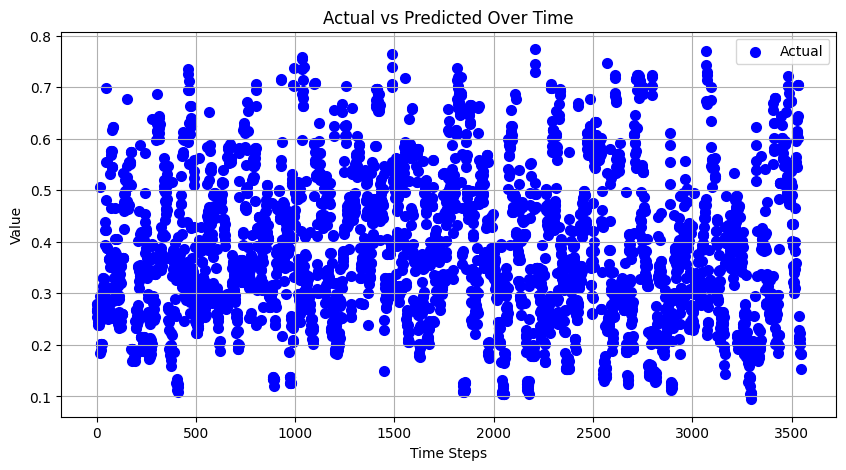

In [17]:
y_probs = model.predict_proba(X_test)
y_pos_prob = y_probs[y_test==True][:,1]
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_pos_prob)), y_pos_prob, label="Actual", color='blue', linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.show()

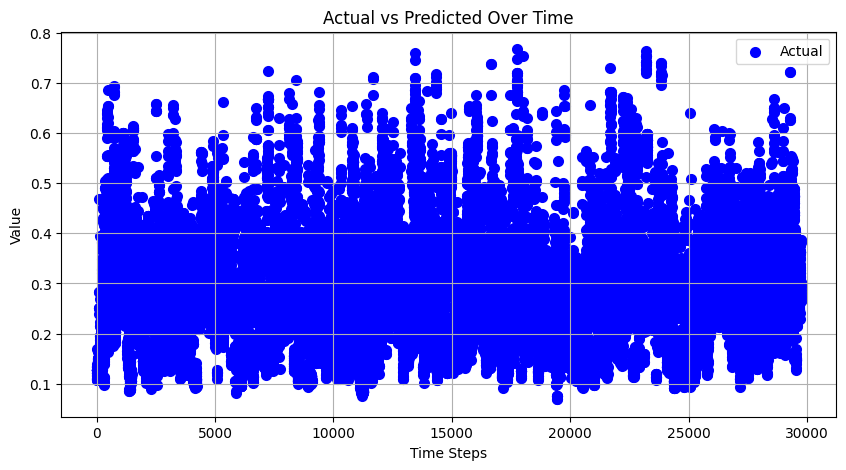

In [18]:
y_neg_prob = y_probs[y_test==False][:,1]
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_neg_prob)), y_neg_prob, label="Actual", color='blue', linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
y_probs = model.predict_proba(X_test)[:, 1]
new_threshold = .67
y_pred = np.array(np.where(y_probs > new_threshold, 1, 0))
# Evaluate performance

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(confusion_matrix(y_test,y_pred))

Test Accuracy: 0.8943
[[29645    96]
 [ 3422   126]]


In [20]:
# Assume 'model' is your trained scikit-learn model
filename = '3_update_lag_xgbclassifier1.pkl'
# Save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)

scaler_filename = '3_update_lag_xgbclassifier1_scaler.pkl'
with open(scaler_filename, "wb") as file:
    joblib.dump(scaler, scaler_filename)

In [169]:
df6 = pd.read_csv("/Users/sibysuriyan/Documents/code_projects/TradingApplication/machine_learning/price_levels/price_level7.csv")
test_dfs = [df6]
target_lag_column = "Mid Price"
price_level_num = 10
time_lag = 3
windows = [1,2,5,10]
percent_gain = 0.000000
test_full_df = create_dataset(dfs=test_dfs, target_lag_column = target_lag_column, price_level_num = price_level_num, time_lag = time_lag, windows = windows, percent_gain = percent_gain)

In [170]:
test_full_proba = model.predict_proba(test_full_df[feature_columns])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [168]:
test_full_proba

array([[0.01402186, 0.98597814],
       [0.01402186, 0.98597814],
       [0.01402186, 0.98597814],
       ...,
       [0.01615417, 0.98384583],
       [0.01615417, 0.98384583],
       [0.01615417, 0.98384583]])

In [ ]:
test_full_y = test_full_df[target_gain]
test_full_X = test_full_df[feature_columns]
test_full_X = scaler.transform(test_full_X)
test_full_y_probs = model.predict_proba(test_full_X)[:, 1]

new_threshold = .8
test_full_y_pred = np.array(np.where(test_full_y_probs > new_threshold, 1, 0))
print(confusion_matrix(test_full_y, test_full_y_pred))
accuracy = accuracy_score(test_full_y, test_full_y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print((test_full_df[test_full_y_pred==1]["Mid Price Time Lag 3"] - test_full_df[test_full_y_pred==1]["Mid Price"]).sum())
false_positives = ((test_full_y == 0) & (test_full_y_pred == 1)).sum()
print(f'False Positives: {false_positives}')

[[19678   905]
 [13614  1394]]
Test Accuracy: 0.5921
1917.5549999995274
False Positives: 905


In [104]:
test_full_y_probs

array([[0.86396106, 0.13603894],
       [0.43188695, 0.56811305],
       [0.5746501 , 0.4253499 ],
       ...,
       [0.56877353, 0.43122647],
       [0.45432838, 0.54567162],
       [0.46131088, 0.53868912]])

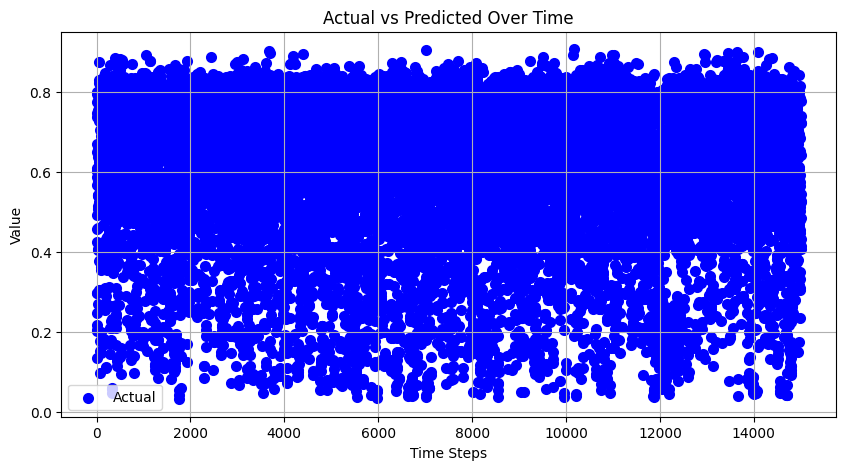

In [89]:
test_full_y_probs = model.predict_proba(test_full_X)
test_full_y_pos_prob = test_full_y_probs[test_full_y==True][:,1]
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(test_full_y_pos_prob)), test_full_y_pos_prob, label="Actual", color='blue', linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.show()

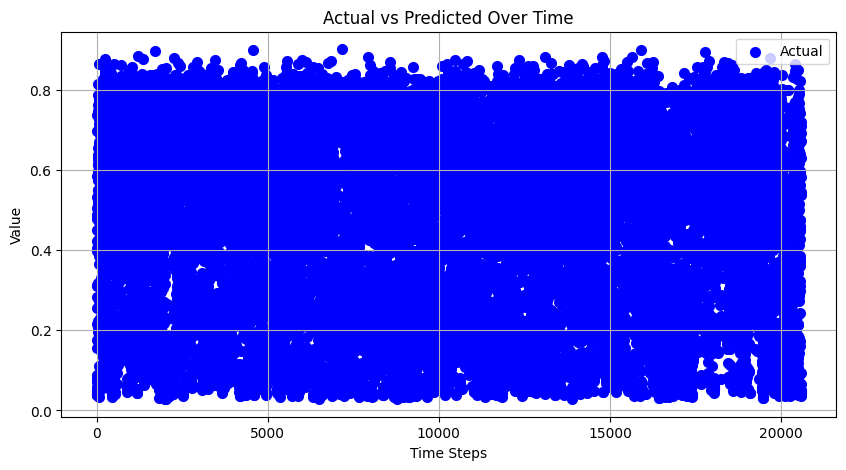

In [90]:
test_full_y_neg_prob = test_full_y_probs[test_full_y==False][:,1]
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(test_full_y_neg_prob)), test_full_y_neg_prob, label="Actual", color='blue', linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
##########################################
###### EVALUATE INFERENCE PROCESS ########
##########################################
class BinaryClassifier:
    def __init__(self, price_level_num):
        self.price_level_num = price_level_num
        self.historical_inference_vectors = pd.DataFrame()

    def bc_create_inference_vector(self, bids, asks, timestamp_str):
        inf_row = {}

        for i in range(self.price_level_num):
            inf_row[f"Bid Price Level {i+1}"] = bids[i][0]
            inf_row[f"Bid Volume Level {i+1}"] = bids[i][1]

        for i in range(self.price_level_num):
            inf_row[f"Ask Price Level {i+1}"] = asks[i][0]
            inf_row[f"Ask Volume Level {i+1}"] = asks[i][1]


        inf_row["Timestamp"] = timestamp_str

        inf_df = pd.DataFrame([inf_row])

        inf_df = self.bc_time_independent_features(inf_df, self.price_level_num)

        inf_df = self.bc_time_dependent_features(inf_df, [1,2,5,10])


        self.historical_inference_vectors = pd.concat([self.historical_inference_vectors,inf_df], ignore_index= True)

        if len(self.historical_inference_vectors) >= 500:

            self.historical_inference_vectors = self.historical_inference_vectors.tail(200)
            

        return inf_df




    def bc_time_independent_features(self,df, price_level_num):

        # Mid Price
        df["Mid Price"] = (df["Bid Price Level 1"] + df["Ask Price Level 1"]) / 2

        # Mid Price Velocity
        if len(self.historical_inference_vectors) < 1:
            df["Mid Price Velocity"] = np.nan
        else:
            df["Mid Price Velocity"] = df["Mid Price"] - self.historical_inference_vectors.iloc[-1]["Mid Price"] # df["Mid Price"].shift(1)

        # Mid Price Acceleration
        if len(self.historical_inference_vectors) < 2:
            df["Mid Price Acceleration"] = np.nan
        else:
            df["Mid Price Acceleration"] = df["Mid Price Velocity"] - self.historical_inference_vectors.iloc[-1]["Mid Price Velocity"] # df["Mid Price Velocity"].shift(1)
        
        # Bid Ask Spread
        df["Bid Ask Spread"] = (df["Bid Price Level 1"] - df["Ask Price Level 1"])
        
        # Volume Level Log Bid & Ask
        for i in range(price_level_num):
            df[f"Bid Volume Level {i+1} Log"] = np.log(df[f"Bid Volume Level {i+1}"])
        for i in range(price_level_num):
            df[f"Ask Volume Level {i+1} Log"] = np.log(df[f"Ask Volume Level {i+1}"])
        
        # Volume Level Difference Bid & Ask
        for i in range(1,price_level_num):
            df[f'Bid Volume Diff {i}'] = df[f'Bid Volume Level {i+1}'] - df[f'Bid Volume Level {i}']
        for i in range(1,price_level_num):
            df[f'Ask Volume Diff {i}'] = df[f'Ask Volume Level {i+1}'] - df[f'Ask Volume Level {i}']
        
        # Imbalance
        df["Imbalance"] = (df["Bid Volume Level 1"] - df["Ask Volume Level 1"]) / (df["Bid Volume Level 1"] + df["Ask Volume Level 1"])
        
        # VWAP Bid & Ask
        def vwap_helper(df, side, levels):
            total_volume = sum(df[[f"{side} Volume Level {i}" for i in range(1,levels+1)]].values)
            vwap = sum(df[f'{side} Price Level {i}'] * df[f'{side} Volume Level {i}'] for i in range(1, levels+1)) / total_volume
            return vwap
        df[f"Bid VWAP {price_level_num}"] = df.apply(lambda row: vwap_helper(row, "Bid", price_level_num), axis = 1)
        df[f"Ask VWAP {price_level_num}"] = df.apply(lambda row: vwap_helper(row, "Ask", price_level_num), axis = 1)
       
        # Total Volume Bid & Ask
        df[f"Total Bid Volume {price_level_num}"] = df[[f'Bid Volume Level {i}' for i in range(1, price_level_num+1)]].sum(axis=1)
        df[f"Total Ask Volume {price_level_num}"] = df[[f'Ask Volume Level {i}' for i in range(1, price_level_num+1)]].sum(axis=1)
        
        # Price Range
        df["Price Range"] = df["Ask Price Level 10"] - df["Bid Price Level 10"]
        
        # Time Difference
        df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='ISO8601')
        if len(self.historical_inference_vectors) >= 1:
            df['Time Since Last Update'] = (df['Timestamp'] - self.historical_inference_vectors.iloc[-1]["Timestamp"]).dt.total_seconds()
        else:
            df['Time Since Last Update'] = np.nan

        return df


    def bc_time_dependent_features(self, df, windows):

        temp_df = pd.concat([self.historical_inference_vectors, df], ignore_index = True)
                
        # Mid Price Volatility Calculation
        def volatility_helper(series, window):
            if len(series) >= window:
                std = series.tail(window).std()
                return std
            return np.nan
        
        for window in windows:
            if window == 1:
                continue
            df[f"Mid Price Volatility {window}"] = volatility_helper(temp_df["Mid Price"], window)

        

        def create_sma_helper(series, window):

            if len(series) < window:
                return np.nan

            return sum(series.tail(window)) / window
        
        for window in windows:
            df[f"Mid Price SMA {window}"] = create_sma_helper(temp_df["Mid Price"], window)


        
        def create_rate_of_change_helper(series):
            if len(series) < 2:
                return np.nan

            return (series.iloc[-1] - series.iloc[-2]) / (series.iloc[-2])
        
        df[f"Mid Price ROC"] = create_rate_of_change_helper(temp_df["Mid Price"])


        
        def create_ema_helper(series, window):
            alpha = 2 / (window+1)
            ema = [None]*len(series)
            if len(self.historical_inference_vectors) == 0:
                ema[0] = df["Mid Price"]
            else:
                ema[0] = self.historical_inference_vectors.iloc[-1][f"Mid Price EMA {window}"]

            for i in range(1, len(series)):
                ema[i] = (alpha * series[i] + (1-alpha) * ema[i-1])
            return ema[-1]
        
        for window in windows:
            df[f"Mid Price EMA {window}"] = create_ema_helper(temp_df["Mid Price"], window)


        
        def create_rsi_helper(series, window):
            deltas = [None]*len(series)
            for i in range(1,len(series)):
                deltas[i] = series[i] - series[i-1]
        
            gains = [max(delta, 0) if delta is not None else None for delta in deltas]
            losses = [-min(delta, 0) if delta is not None else None for delta in deltas]
        
            avg_gain = create_sma_helper(pd.Series(gains),window)
            avg_loss = create_sma_helper(pd.Series(losses),window)

            if avg_loss == None or avg_gain == None:
                return None

            if avg_loss == 0:
                return 100

            rs = avg_gain / avg_loss
                
            rsi =  (100 - (100 / (1 + rs)))
            
            return rsi
        

        df["Mid Price RSI"] = create_rsi_helper(temp_df["Mid Price"], window=14)

        return df



    



    def create_training_check(self, df, price_level_num, windows):
        df_copy = df.copy()
        df_copy = time_independent_features(df_copy, price_level_num)
        df_copy = time_dependent_features(df_copy, windows)
        return df_copy




In [111]:
binary_classifier = BinaryClassifier(10)
df1 = df11.copy()
inf_rows = []
for i in range(len(df1)):
    update_row = df1.iloc[i]
    timestamp_str = update_row["Timestamp"]
    bids = []
    asks = []
    for j in range(10):
        bids.append((update_row[f"Bid Price Level {j+1}"], update_row[f"Bid Volume Level {j+1}"]))
        asks.append((update_row[f"Ask Price Level {j+1}"], update_row[f"Ask Volume Level {j+1}"]))
    inf_row = binary_classifier.bc_create_inference_vector(bids,asks, timestamp_str)
    inf_rows.append(inf_row)
inf_df = pd.concat(inf_rows)
inf_df = inf_df.dropna(ignore_index=True)
windows = [1,2,5,10]
train_df = binary_classifier.create_training_check(df1, 10, windows)
train_df = train_df.dropna(ignore_index=True)

In [118]:
test_full_df_proba = model.predict_proba((test_full_df.iloc[23][feature_columns]).to_frame().T)
print(test_full_df_proba)
train_df_df_proba = model.predict_proba((train_df.iloc[23][feature_columns]).to_frame().T)
print(train_df_df_proba)

[[0.03471061 0.96528939]]
[[0.03471061 0.96528939]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [112]:
test_full_df

,Bid Price Level 1,Bid Volume Level 1,Bid Price Level 2,Bid Volume Level 2,Bid Price Level 3,Bid Volume Level 3,Bid Price Level 4,Bid Volume Level 4,Bid Price Level 5,Bid Volume Level 5,Bid Price Level 6,Bid Volume Level 6,Bid Price Level 7,Bid Volume Level 7,Bid Price Level 8,Bid Volume Level 8,Bid Price Level 9,Bid Volume Level 9,Bid Price Level 10,Bid Volume Level 10,Ask Price Level 1,Ask Volume Level 1,Ask Price Level 2,Ask Volume Level 2,Ask Price Level 3,Ask Volume Level 3,Ask Price Level 4,Ask Volume Level 4,Ask Price Level 5,Ask Volume Level 5,Ask Price Level 6,Ask Volume Level 6,Ask Price Level 7,Ask Volume Level 7,Ask Price Level 8,Ask Volume Level 8,Ask Price Level 9,Ask Volume Level 9,Ask Price Level 10,Ask Volume Level 10,Timestamp,Mid Price,Mid Price Velocity,Mid Price Acceleration,Bid Ask Spread,Bid Volume Level 1 Log,Bid Volume Level 2 Log,Bid Volume Level 3 Log,Bid Volume Level 4 Log,Bid Volume Level 5 Log,Bid Volume Level 6 Log,Bid Volume Level 7 Log,Bid Volume Level 8 Log,Bid Volume Level 9 Log,Bid Volume Level 10 Log,Ask Volume Level 1 Log,Ask Volume Level 2 Log,Ask Volume Level 3 Log,Ask Volume Level 4 Log,Ask Volume Level 5 Log,Ask Volume Level 6 Log,Ask Volume Level 7 Log,Ask Volume Level 8 Log,Ask Volume Level 9 Log,Ask Volume Level 10 Log,Bid Volume Diff 1,Bid Volume Diff 2,Bid Volume Diff 3,Bid Volume Diff 4,Bid Volume Diff 5,Bid Volume Diff 6,Bid Volume Diff 7,Bid Volume Diff 8,Bid Volume Diff 9,Ask Volume Diff 1,Ask Volume Diff 2,Ask Volume Diff 3,Ask Volume Diff 4,Ask Volume Diff 5,Ask Volume Diff 6,Ask Volume Diff 7,Ask Volume Diff 8,Ask Volume Diff 9,Imbalance,Bid VWAP 10,Ask VWAP 10,Total Bid Volume 10,Total Ask Volume 10,Price Range,Time Since Last Update,Mid Price Volatility 2,Mid Price Volatility 5,Mid Price Volatility 10,Mid Price SMA 1,Mid Price SMA 2,Mid Price SMA 5,Mid Price SMA 10,Mid Price ROC,Mid Price EMA 1,Mid Price EMA 2,Mid Price EMA 5,Mid Price EMA 10,Mid Price RSI,Mid Price Time Lag 3,Mid Price 0.0 Gain
0,87846.31,0.000908,87844.62,0.028459,87837.02,3.082000e-05,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87823.71,0.000114,87823.32,0.000014,87821.97,0.000032,87846.32,0.118101,87846.97,0.002710,87850.00,0.400000,87850.31,0.029476,87850.32,0.034111,87850.34,0.377000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,2025-03-04 20:33:56.250,87846.315,0.000,0.000,-0.01,-7.003881,-3.559279,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-9.080541,-11.178598,-10.354159,-2.136215,-5.910799,-0.916291,-3.524179,-3.378122,-0.975510,-0.540526,-0.916291,-0.916291,-2.683739,0.027551,-0.028429,0.113816,-0.063323,0.653576,-0.634811,-0.069175,-0.000100,0.000018,-1.153910e-01,0.397290,-0.370524,0.004635,0.342889,0.205442,-0.182442,0.000000,-0.331693,-0.984735,87833.985100,87852.095238,0.967319,2.412148,33.99,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,87845.315,87846.315,87846.317593,87846.325370,87846.325456,50.000000,87846.965,True
1,87846.31,0.147998,87845.83,0.028459,87837.02,3.082000e-05,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87828.73,0.114700,87823.71,0.000114,87823.32,0.000014,87846.32,0.000197,87846.97,0.002710,87850.33,0.437925,87850.34,0.377000,87851.00,0.400000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,87855.99,0.962906,2025-03-04 20:33:56.270,87846.315,0.000,0.000,-0.01,-1.910554,-3.559293,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-2.165435,-9.080541,-11.178598,-8.529975,-5.910799,-0.825708,-0.975510,-0.916291,-0.540526,-0.916291,-0.916291,-2.683739,-0.037799,-0.119539,-0.028428,0.113816,-0.063323,0.653576,-0.634811,0.045411,-0.114586,-0.000100,2.512560e-03,0.435215,-0.060925,0.023000,0.182442,-0.182442,0.000000,-0.331693,0.894599,0.997335,87834.997993,87853.243898,1.229076,3.631488,32.67,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,87845.315,87846.315,87846.315864,87846.321914,87846.323555,50.000

In [113]:
train_df

,Bid Price Level 1,Bid Volume Level 1,Bid Price Level 2,Bid Volume Level 2,Bid Price Level 3,Bid Volume Level 3,Bid Price Level 4,Bid Volume Level 4,Bid Price Level 5,Bid Volume Level 5,Bid Price Level 6,Bid Volume Level 6,Bid Price Level 7,Bid Volume Level 7,Bid Price Level 8,Bid Volume Level 8,Bid Price Level 9,Bid Volume Level 9,Bid Price Level 10,Bid Volume Level 10,Ask Price Level 1,Ask Volume Level 1,Ask Price Level 2,Ask Volume Level 2,Ask Price Level 3,Ask Volume Level 3,Ask Price Level 4,Ask Volume Level 4,Ask Price Level 5,Ask Volume Level 5,Ask Price Level 6,Ask Volume Level 6,Ask Price Level 7,Ask Volume Level 7,Ask Price Level 8,Ask Volume Level 8,Ask Price Level 9,Ask Volume Level 9,Ask Price Level 10,Ask Volume Level 10,Timestamp,Mid Price,Mid Price Velocity,Mid Price Acceleration,Bid Ask Spread,Bid Volume Level 1 Log,Bid Volume Level 2 Log,Bid Volume Level 3 Log,Bid Volume Level 4 Log,Bid Volume Level 5 Log,Bid Volume Level 6 Log,Bid Volume Level 7 Log,Bid Volume Level 8 Log,Bid Volume Level 9 Log,Bid Volume Level 10 Log,Ask Volume Level 1 Log,Ask Volume Level 2 Log,Ask Volume Level 3 Log,Ask Volume Level 4 Log,Ask Volume Level 5 Log,Ask Volume Level 6 Log,Ask Volume Level 7 Log,Ask Volume Level 8 Log,Ask Volume Level 9 Log,Ask Volume Level 10 Log,Bid Volume Diff 1,Bid Volume Diff 2,Bid Volume Diff 3,Bid Volume Diff 4,Bid Volume Diff 5,Bid Volume Diff 6,Bid Volume Diff 7,Bid Volume Diff 8,Bid Volume Diff 9,Ask Volume Diff 1,Ask Volume Diff 2,Ask Volume Diff 3,Ask Volume Diff 4,Ask Volume Diff 5,Ask Volume Diff 6,Ask Volume Diff 7,Ask Volume Diff 8,Ask Volume Diff 9,Imbalance,Bid VWAP 10,Ask VWAP 10,Total Bid Volume 10,Total Ask Volume 10,Price Range,Time Since Last Update,Mid Price Volatility 2,Mid Price Volatility 5,Mid Price Volatility 10,Mid Price SMA 1,Mid Price SMA 2,Mid Price SMA 5,Mid Price SMA 10,Mid Price ROC,Mid Price EMA 1,Mid Price EMA 2,Mid Price EMA 5,Mid Price EMA 10,Mid Price RSI
0,87846.31,0.000908,87844.62,0.028459,87837.02,0.000031,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87823.71,0.000114,87823.32,0.000014,87821.97,0.000032,87846.32,0.118101,87846.97,0.002710,87850.00,0.400000,87850.31,0.029476,87850.32,0.034111,87850.34,0.377000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,2025-03-04 20:33:56.250,87846.315,0.000,0.000,-0.01,-7.003881,-3.559279,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-9.080541,-11.178598,-10.354159,-2.136215,-5.910799,-0.916291,-3.524179,-3.378122,-0.975510,-0.540526,-0.916291,-0.916291,-2.683739,0.027551,-0.028429,0.113816,-0.063323,0.653576,-0.634811,-0.069175,-0.000100,0.000018,-0.115391,0.397290,-0.370524,0.004635,0.342889,0.205442,-0.182442,0.000000,-0.331693,-0.984735,87833.985100,87852.095238,0.967319,2.412148,33.99,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,87845.315,87846.315,87846.317593,87846.325370,87846.325456,50.000000
1,87846.31,0.147998,87845.83,0.028459,87837.02,0.000031,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87828.73,0.114700,87823.71,0.000114,87823.32,0.000014,87846.32,0.000197,87846.97,0.002710,87850.33,0.437925,87850.34,0.377000,87851.00,0.400000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,87855.99,0.962906,2025-03-04 20:33:56.270,87846.315,0.000,0.000,-0.01,-1.910554,-3.559293,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-2.165435,-9.080541,-11.178598,-8.529975,-5.910799,-0.825708,-0.975510,-0.916291,-0.540526,-0.916291,-0.916291,-2.683739,-0.037799,-0.119539,-0.028428,0.113816,-0.063323,0.653576,-0.634811,0.045411,-0.114586,-0.000100,0.002513,0.435215,-0.060925,0.023000,0.182442,-0.182442,0.000000,-0.331693,0.894599,0.997335,87834.997993,87853.243898,1.229076,3.631488,32.67,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,87845.315,87846.315,87846.315864,87846.321914,87846.323555,50.000000
2,87846.31,0.014738,87845.31,0.028459,87843.27,0.113839,87837.02,8.

In [114]:
inf_df

,Bid Price Level 1,Bid Volume Level 1,Bid Price Level 2,Bid Volume Level 2,Bid Price Level 3,Bid Volume Level 3,Bid Price Level 4,Bid Volume Level 4,Bid Price Level 5,Bid Volume Level 5,Bid Price Level 6,Bid Volume Level 6,Bid Price Level 7,Bid Volume Level 7,Bid Price Level 8,Bid Volume Level 8,Bid Price Level 9,Bid Volume Level 9,Bid Price Level 10,Bid Volume Level 10,Ask Price Level 1,Ask Volume Level 1,Ask Price Level 2,Ask Volume Level 2,Ask Price Level 3,Ask Volume Level 3,Ask Price Level 4,Ask Volume Level 4,Ask Price Level 5,Ask Volume Level 5,Ask Price Level 6,Ask Volume Level 6,Ask Price Level 7,Ask Volume Level 7,Ask Price Level 8,Ask Volume Level 8,Ask Price Level 9,Ask Volume Level 9,Ask Price Level 10,Ask Volume Level 10,Timestamp,Mid Price,Mid Price Velocity,Mid Price Acceleration,Bid Ask Spread,Bid Volume Level 1 Log,Bid Volume Level 2 Log,Bid Volume Level 3 Log,Bid Volume Level 4 Log,Bid Volume Level 5 Log,Bid Volume Level 6 Log,Bid Volume Level 7 Log,Bid Volume Level 8 Log,Bid Volume Level 9 Log,Bid Volume Level 10 Log,Ask Volume Level 1 Log,Ask Volume Level 2 Log,Ask Volume Level 3 Log,Ask Volume Level 4 Log,Ask Volume Level 5 Log,Ask Volume Level 6 Log,Ask Volume Level 7 Log,Ask Volume Level 8 Log,Ask Volume Level 9 Log,Ask Volume Level 10 Log,Bid Volume Diff 1,Bid Volume Diff 2,Bid Volume Diff 3,Bid Volume Diff 4,Bid Volume Diff 5,Bid Volume Diff 6,Bid Volume Diff 7,Bid Volume Diff 8,Bid Volume Diff 9,Ask Volume Diff 1,Ask Volume Diff 2,Ask Volume Diff 3,Ask Volume Diff 4,Ask Volume Diff 5,Ask Volume Diff 6,Ask Volume Diff 7,Ask Volume Diff 8,Ask Volume Diff 9,Imbalance,Bid VWAP 10,Ask VWAP 10,Total Bid Volume 10,Total Ask Volume 10,Price Range,Time Since Last Update,Mid Price Volatility 2,Mid Price Volatility 5,Mid Price Volatility 10,Mid Price SMA 1,Mid Price SMA 2,Mid Price SMA 5,Mid Price SMA 10,Mid Price ROC,Mid Price EMA 1,Mid Price EMA 2,Mid Price EMA 5,Mid Price EMA 10,Mid Price RSI
0,87846.31,0.000908,87844.62,0.028459,87837.02,0.000031,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87823.71,0.000114,87823.32,0.000014,87821.97,0.000032,87846.32,0.118101,87846.97,0.002710,87850.00,0.400000,87850.31,0.029476,87850.32,0.034111,87850.34,0.377000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,2025-03-04 20:33:56.250,87846.315,0.000,0.000,-0.01,-7.003881,-3.559279,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-9.080541,-11.178598,-10.354159,-2.136215,-5.910799,-0.916291,-3.524179,-3.378122,-0.975510,-0.540526,-0.916291,-0.916291,-2.683739,0.027551,-0.028429,0.113816,-0.063323,0.653576,-0.634811,-0.069175,-0.000100,0.000018,-0.115391,0.397290,-0.370524,0.004635,0.342889,0.205442,-0.182442,0.000000,-0.331693,-0.984735,87833.985100,87852.095238,0.967319,2.412148,33.99,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,0.000000e+00,87846.315,87846.317593,87846.325424,87846.326303,50.000000
1,87846.31,0.147998,87845.83,0.028459,87837.02,0.000031,87837.01,1.138472e-01,87833.44,0.050524,87833.41,0.704100,87830.75,0.069289,87828.73,0.114700,87823.71,0.000114,87823.32,0.000014,87846.32,0.000197,87846.97,0.002710,87850.33,0.437925,87850.34,0.377000,87851.00,0.400000,87852.99,0.582442,87853.00,0.400000,87855.00,0.400000,87855.96,0.068307,87855.99,0.962906,2025-03-04 20:33:56.270,87846.315,0.000,0.000,-0.01,-1.910554,-3.559293,-10.387347,-2.172898,-2.985307,-0.350835,-2.669467,-2.165435,-9.080541,-11.178598,-8.529975,-5.910799,-0.825708,-0.975510,-0.916291,-0.540526,-0.916291,-0.916291,-2.683739,-0.037799,-0.119539,-0.028428,0.113816,-0.063323,0.653576,-0.634811,0.045411,-0.114586,-0.000100,0.002513,0.435215,-0.060925,0.023000,0.182442,-0.182442,0.000000,-0.331693,0.894599,0.997335,87834.997993,87853.243898,1.229076,3.631488,32.67,0.02,0.000000,0.046957,0.033204,87846.315,87846.3150,87846.336,87846.3255,0.000000e+00,87846.315,87846.315864,87846.321937,87846.324112,50.000000
2,87846.31,0.014738,87845.31,0.028459,87843.27,0.113839,87837

In [94]:
inference_vectors_features = inf_df[feature_columns]
training_vectors_features = train_df[feature_columns]
for i in range(len(training_vectors_features)):
    for feature_column in feature_columns:
        if inference_vectors_features.iloc[i][feature_column] != training_vectors_features.iloc[i][feature_column]:
            inf = inference_vectors_features.iloc[i][feature_column]
            tra = training_vectors_features.iloc[i][feature_column]
            print(f"Row {i}, feature: {feature_column}, inference: {inf}, training: {tra}")
    

Row 0, feature: Mid Price Velocity, inference: nan, training: nan
Row 0, feature: Mid Price Acceleration, inference: nan, training: nan
Row 0, feature: Time Since Last Update, inference: nan, training: nan
Row 0, feature: Mid Price Volatility 2, inference: nan, training: nan
Row 0, feature: Mid Price Volatility 5, inference: nan, training: nan
Row 0, feature: Mid Price Volatility 10, inference: nan, training: nan
Row 0, feature: Mid Price RSI, inference: nan, training: nan
Row 1, feature: Mid Price Acceleration, inference: nan, training: nan
Row 1, feature: Mid Price Volatility 5, inference: nan, training: nan
Row 1, feature: Mid Price Volatility 10, inference: nan, training: nan
Row 1, feature: Mid Price RSI, inference: nan, training: nan
Row 2, feature: Mid Price Volatility 5, inference: nan, training: nan
Row 2, feature: Mid Price Volatility 10, inference: nan, training: nan
Row 2, feature: Mid Price RSI, inference: nan, training: nan
Row 3, feature: Mid Price Volatility 5, inferenc

In [108]:
inf_df = inf_df.dropna(ignore_index=True)
training_vectors_features = inf_df[feature_columns]
train_probs = model.predict_proba(training_vectors_features)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [107]:
train_probs

array([[0.06924701, 0.93075299],
       [0.03033514, 0.96966486],
       [0.03033514, 0.96966486],
       ...,
       [0.05532461, 0.94467539],
       [0.05532461, 0.94467539],
       [0.05002297, 0.94997703]])

In [97]:
inf_probs

array([[0.06924701, 0.93075299],
       [0.03033514, 0.96966486],
       [0.03033514, 0.96966486],
       ...,
       [0.05532461, 0.94467539],
       [0.05532461, 0.94467539],
       [0.05002297, 0.94997703]])